# Загрузка Pandas и очистка данных

In [3573]:
import pandas as pd
import json
import numpy as np
from datetime import datetime
import ast
import matplotlib.pyplot as plt
import math 
from selenium import webdriver
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from sklearn.preprocessing import MinMaxScaler

In [3574]:
# Загрузка всех файлов

df = pd.read_csv('/Users/tanchik/Downloads/main_task_new.csv')

with open('/Users/tanchik/Downloads/coordinates.json') as f:
    coordinates = json.load(f) # Спарсила координаты каждого ресторана с сайта TripAdvisor и сохраниала в json файл.
    
world_cities = pd.read_csv('/Users/tanchik/Downloads/worldcities.csv')
world_cities.shape
world_cities.drop_duplicates(subset='city', keep='first', inplace=True)

In [3575]:
URL_TA = []
for i in coordinates:
    URL_TA.append(i[26:])

In [3576]:
lat_rest = []
for i in coordinates:
    lat_rest.append(coordinates[i]['lat'])

In [3577]:
# На начальном этапе создам переменную, которая определяет, существует ресторан сегодня или нет. 

is_it_exists = []
for i in lat_rest:
    if i == 1:
        is_it_exists.append(0)
    else:
        is_it_exists.append(1)

In [3578]:
lng_rest = []
for i in coordinates:
    lng_rest.append(coordinates[i]['lang'])
len(lng_rest)

39980

In [3579]:
for i in range(len(lat_rest)):
    if lat_rest[i] == -1:
        lat_rest[i] = 1
        lng_rest[i] =1


In [3580]:
recoordinates_of_restaurants = pd.DataFrame({'URL_TA':URL_TA, 'lat_rest':lat_rest, 'lng_rest':lng_rest, 'is_it_exists':is_it_exists})

In [3581]:
#### Проанализируем каждый признак и заполним все пропуски

Параметры без пропущенных значений: Restaurant_id, City, Ranking, Rating, Reviews, URL_TA, ID_TA
Данные в числовом формате: Ranking, Rating, Number of Reviews

In [3582]:
# Посчитаем процент пропусков в столбцах:

for column in ['Cuisine Style', 'Price Range', 'Number of Reviews']:
    print(f'Процент пропусков для {column}: {df[column].isnull().mean()*100}%')

Процент пропусков для Cuisine Style: 23.2075%
Процент пропусков для Price Range: 34.715%
Процент пропусков для Number of Reviews: 6.357500000000001%


Мы видим, что количество пропусков меньше 70% -> наша задача заменить пропуски

In [3583]:
# Заменим пропуски в колонке Price Range самым частым значением

print(f'Самое часто встречаемое значение: {df["Price Range"].value_counts().index[0]}')
df['Price Range'].fillna('$$ - $$$', inplace=True)
df['Price Range'].isnull().sum()

Самое часто встречаемое значение: $$ - $$$


0

In [3584]:
# Создадим список кухонь для каждого ресторана

df['Cuisine Style NaN'] = pd.isna(df['Cuisine Style']).astype('uint8')
df['Cuisine Style'].fillna('Local cuisine', inplace=True)

Text(0.5, 1.0, 'Ranking')

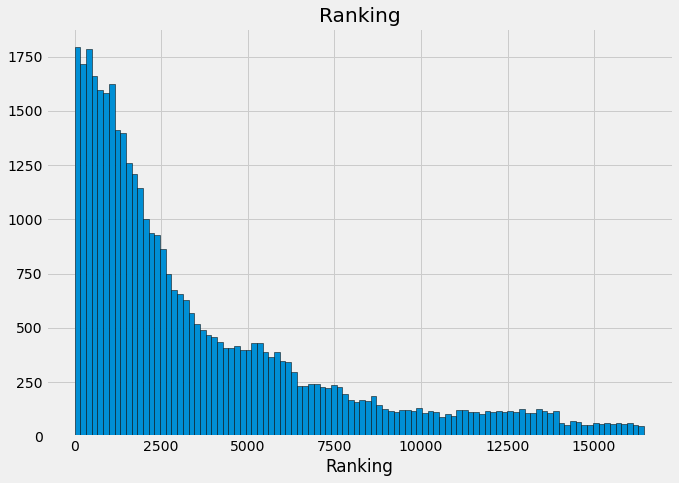

In [3585]:
plt.style.use('fivethirtyeight')
plt.hist(df['Ranking'], bins = 100, edgecolor = 'k')
plt.xlabel('Ranking') 
plt.title('Ranking')

Мы видим, что распределение смещено влево, разброс ранга по городам огромный.

<AxesSubplot:>

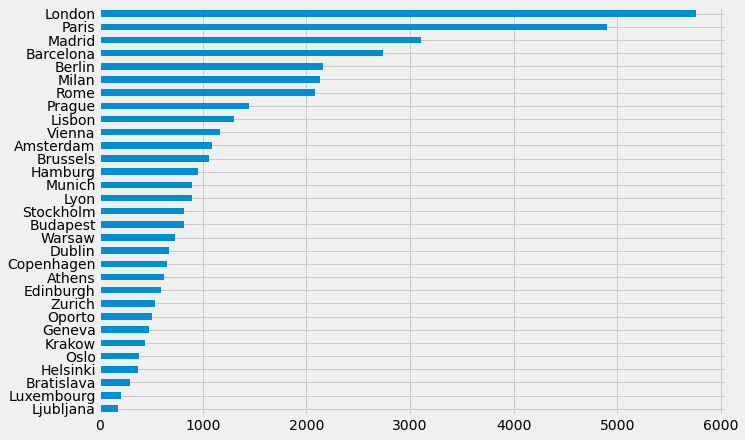

In [3586]:
plt.rcParams['figure.figsize'] = (10,7)
df['City'].value_counts(ascending=True).plot(kind='barh')

Мы видим, что ресторанов в Лондоне больше всего. Чем больше ресторанов, тем разнообразнее может быть ранг. Посмотрим распределение Ranking по первым 15 городам:

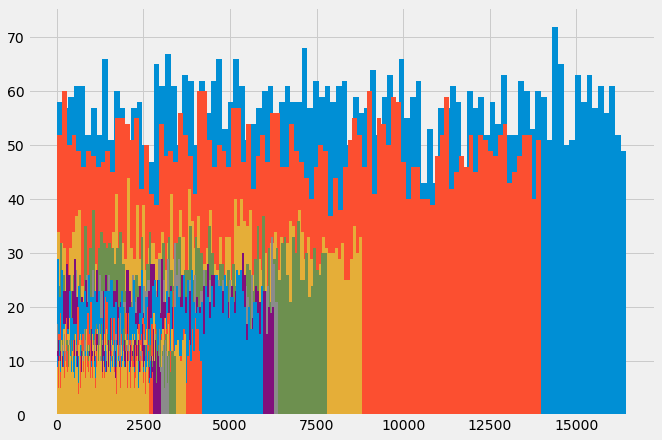

In [3587]:
for i in (df['City'].value_counts())[0:15].index:
    df['Ranking'][df['City'] == i].hist(bins=100)
plt.show()

Есть предположения, что надо использовать нормализацию. Осуществлю ее в конце над всеми данными.
На основе этой информации введу два новых признака: 
1) Отношение ранга ресторана к общему колучеству ресторанов в городе
2) Количество ресторанов на душу населения в городе

### Создание новых признаков

In [3588]:
# Преобразуем колонку Cuisine_style в список

df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'",'').replace(' ', '').split(','))

# Создадим признак количество кухонь в каждом ресторане

df['cuisine_style_amount'] = df['Cuisine Style'].apply(lambda x: len(x))

In [3589]:
# Отсортируем список кухнь

new_cuisine = {'Europen' : ['European', 'French', 'German', 'CentralEuropean', 'Italian', 
                            'Pizza', 'Mediterranean', 'Spanish', 'Café', 'Soups', 'British', 
                            'Polish', 'Dutch', 'Belgian', 'Irish', 'Seafood', 'Swiss', 'Portuguese',
                            'Greek', 'Turkish', 'Hungarian', 'EasternEuropean', 'Swedish', 'Scandinavian',
                            'Southwestern', 'Czech', 'Slovenian', 'Balti', 'Austrian', 'Russian', 'Danish', 'Scottish',
                            'Ukrainian', 'Norwegian', 'Albanian', 'Croatian', 'Cajun&Creole', 'Romanian', 'Welsh', 'Latvian'],
              'Shared kitchen' : ['International', 'Localcuisine', 'Café', 'Fusion', 'Contemporary', 'Delicatessen', 'Soups', 'Diner', 'StreetFood', 'Gastropub'],
              'Asian' : ['Japanese', 'Sushi', 'Asian', 'Thai', 'Vietnamese', 'Chinese', 'Seafood', 'Indian', 'Pakistani',
                         'Peruvian', 'Tibetan', 'Nepali', 'Korean', 'StreetFood', 'Soups', 'Singaporean', 'Malaysian', 
                         'MinorityChinese', 'Mongolian', 'Persian', 'Indonesian', 'Armenian', 'Taiwanese', 'Bangladeshi',
                         'SriLankan', 'Cambodian', 'CentralAsian', 'Filipino', 'Georgian', 'Azerbaijani', 'Caucasian', 
                         'Afghani', 'Uzbek', 'Yunnan', 'Xinjiang', 'Burmese', 'Fujian'],
              'Meat' : ['Grill', 'Steakhouse', 'Barbecue'],
              'Kitchen for vegetarians' : ['VegetarianFriendly', 'VeganOptions'],
              'Healthy' : ['VegetarianFriendly', 'VeganOptions', 'GlutenFreeOptions', 'Healthy', 'Halal', 'Kosher'],
              'American' : ['FastFood', 'Mexican', 'Venezuelan', 'SouthAmerican', 'Latin', 'Argentinean', 
                            'CentralAmerican', 'American', 'StreetFood', 'Caribbean', 'Brazilian', 'Ecuadorean',
                            'Chilean', 'Cuban', 'Colombian', 'Jamaican', 'Hawaiian', 'Salvadoran',
                            'NativeAmerican', 'Canadian'],
              'Alcohol' : ['Bar', 'Pub', 'WineBar', 'BrewPub'],
              'African' : ['Moroccan', 'African', 'Ethiopian', 'Egyptian', 'Tunisian'],
              'Eastern' : ['MiddleEastern', 'Lebanese', 'Halal', 'Israeli', 'Kosher', 'Arabic'],
              'Oceania' : ['Australian', 'NewZealand', 'Polynesian']}

In [3590]:
def get_new_cuisine(x):
    temp_set = set()
    for i in new_cuisine:
        for j in new_cuisine[i]:
            for cuisine in x:
                if j == cuisine:
                    temp_set.add(i)
    return list(temp_set)      

df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: get_new_cuisine(x))

In [3591]:
all_cuisine_types = ['Europen', 'Shared kitchen', 'Asian', 'Meat', 'Kitchen for vegetarians', 'Healthy', 'American',
                    'Alcohol', 'African', 'Eastern', 'Oceania']
zero_array = [0 for i in range(0,40000)]

In [3592]:
temp_cuisine_df = pd.DataFrame({'Europen' : zero_array,
                               'Shared kitchen' : zero_array,
                               'Asian' : zero_array,
                               'Meat' : zero_array,
                               'Kitchen for vegetarians' : zero_array,
                               'Healthy' : zero_array,
                               'American' : zero_array,
                               'Alcohol' : zero_array,
                               'African' : zero_array,
                               'Eastern' : zero_array,
                               'Oceania' : zero_array})

In [3593]:
df = pd.concat([df, temp_cuisine_df], axis=1)

In [3594]:
def get_cuisine_columns(x, column):
    if column in x:
        return 1
    else:
        return 0

In [3595]:
for column in all_cuisine_types:
    df[column] = df['Cuisine Style'].apply(lambda x: get_cuisine_columns(x, column))

In [3596]:
df.drop(['Cuisine Style'], inplace=True, axis=1)
df.drop_duplicates(keep='first', inplace=True)

In [3597]:
# Предварительно обработаем колонку Reviews и создадим новый параметр - время отправки комментария

df['Reviews'] = df['Reviews'].apply(lambda x: ast.literal_eval(x.replace(', nan', ', ""').replace('nan, ', '"", ')))
df['time_reviews'] = df['Reviews'].apply(lambda x: x[-1])
df['Reviews'] = df['Reviews'].apply(lambda x: x[0] if len(x) > 0 else None)
df['time_reviews'] = df['time_reviews'].apply(lambda x: [datetime.strptime(x[0], '%m/%d/%Y'), datetime.strptime(x[1],
'%m/%d/%Y')] if len(x) > 1 else [datetime.strptime(x[0], '%m/%d/%Y')] if len(x) != 0 else [])

In [3598]:
# Заменим пропуски в колонке Number of Reviews на количество комментариев в столбце Reviews

def fillna_number_of_reviews_column(x):
    if np.isnan(x['Number of Reviews']):
        return len(x['Reviews'])
    return x['Number of Reviews']

new_number_of_reviews = df.apply(lambda x: fillna_number_of_reviews_column(x), axis=1)
df['Number of Reviews'] = new_number_of_reviews
print(df['Number of Reviews'].isnull().sum())

0


In [3599]:
# Создадим признак разницы между публикациями двух комментариев
# MAE улучшилось до 0.39

df['time_delta'] = df['time_reviews'].apply(lambda x: (x[0].date() - x[1].date()).days if len(x) > 1 else 0 )

In [3600]:
# Так как Price Range является ранговой переменной, присвоем 1, 2 и 3 соответственно '$', '$$ - $$$', '$$$$'

df['Price Range'] = df['Price Range'].apply(lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3 )

df = pd.concat([df, pd.get_dummies(df['Price Range'])], axis=1)

In [3601]:
df['Restaurant_id'].value_counts() # Какие-то рестораны являются сетью -> создадим признак 0 - не сеть, 1 - сеть ресторанов

id_227      18
id_633      18
id_436      18
id_871      18
id_321      17
            ..
id_10171     1
id_14212     1
id_14187     1
id_11165     1
id_9269      1
Name: Restaurant_id, Length: 11909, dtype: int64

In [3602]:
# Создадим новый признак ресторанных сетей. 0 - не сеть, 1 - сеть.

chains_list = list(df['Restaurant_id'].value_counts().iloc[:9082].index)
df['restaurant_chains'] = df['Restaurant_id'].apply(lambda x: 1 if x in chains_list else 0)

In [3603]:
world_cities.rename(columns={'city':'City'}, inplace=True)

In [3604]:
df.columns

Index([          'Restaurant_id',                    'City',
                       'Ranking',                  'Rating',
                   'Price Range',       'Number of Reviews',
                       'Reviews',                  'URL_TA',
                         'ID_TA',       'Cuisine Style NaN',
          'cuisine_style_amount',                 'Europen',
                'Shared kitchen',                   'Asian',
                          'Meat', 'Kitchen for vegetarians',
                       'Healthy',                'American',
                       'Alcohol',                 'African',
                       'Eastern',                 'Oceania',
                  'time_reviews',              'time_delta',
                               1,                         2,
                               3,       'restaurant_chains'],
      dtype='object')

In [3605]:
# Посчитаем расстояние от ресторана до центра города

# Объеденим датасеты с коорднатами центров город и координатами ресторанов
world_cities_lats = world_cities[['City','lat','lng']]
df = df.merge(world_cities_lats, on ='City', how='left')
df = df.merge(recoordinates_of_restaurants, on = 'URL_TA', how='left')
df['lat_rest'].fillna(0, inplace=True)
df['lng_rest'].fillna(0, inplace=True)

# Напишем фуекцию, которая высчитывает расстояние от одной точки до другой

def get_distance(x):
    if x['lat_rest'] != 0:
        lat1 = x['lat'] * math.pi / 180.0
        lat2 = float(x['lat_rest']) * math.pi / 180.0
        lng1 = x['lng'] * math.pi / 180.0
        lng2 = float(x['lng_rest']) * math.pi / 180.0
        rad = 6372795
    
        dlon = lng2 - lng1
        dlat = lat2 - lat1
        a = (math.sin(dlat/2))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(dlon/2))**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = rad * c
        return distance
    else:
        return 0

In [3606]:
df['distance'] = df.apply(lambda x: get_distance(x), axis=1)
df.drop('lat', inplace=True, axis=1)
df.drop('lat_rest', inplace=True, axis=1)
df.drop('lng', inplace=True, axis=1)
df.drop('lng_rest', inplace=True, axis=1)

In [3607]:
df['distance'].fillna(df['distance'].mean(), inplace=True)

In [3608]:
# Добавим признак нселения для города

df = df.merge(world_cities[['City', 'population']], on='City', how='left')
df['population'].fillna(df['population'].mean(), inplace=True)

In [3609]:
# Возьмем данные о количестве ресторанов в кокнкретных городах

urls = []
cities = ['Paris','Stockholm', 'London', 'Berlin', 'Munich', 'Oporto',
       'Milan', 'Bratislava', 'Vienna', 'Rome', 'Barcelona', 'Madrid',
       'Dublin', 'Brussels', 'Zurich', 'Warsaw', 'Budapest', 'Copenhagen',
       'Amsterdam', 'Lyon', 'Hamburg', 'Lisbon', 'Prague', 'Oslo',
       'Helsinki', 'Edinburgh', 'Geneva', 'Ljubljana', 'Athens',
       'Luxembourg', 'Krakow']
for i in cities:
    urls.append('https://www.tripadvisor.com' + df[df['City'] == i]['URL_TA'].iloc[0])
urls[16] = 'https://www.tripadvisor.com/Restaurant_Review-g274887-d8791087-Reviews-Bunny_Chinese_Fast_Food-Budapest_Central_Hungary.html'
urls[18] = 'https://www.tripadvisor.com/Restaurant_Review-g188590-d4588301-Reviews-Villa_Maria_Restaurant_Amsterdam-Amsterdam_North_Holland_Province.html'

In [3610]:
options = Options()
options.add_argument("--headless")

driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome
Driver [/Users/tanchik/.wdm/drivers/chromedriver/mac64/96.0.4664.45/chromedriver] found in cache
<ipython-input-3610-25a8c8853dc7>:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)


In [3611]:
numbers_of_restaurants_in_city_array = []

for url, city in zip(urls, cities):
    driver.get(url)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    rest_quantity = int(soup.find('a', class_='fhGHT').text.split()[2].replace(',', ''))
    print(f'Количесвто ресторанов для {city}: {rest_quantity}')
    numbers_of_restaurants_in_city_array.append(rest_quantity)     

Количесвто ресторанов для Paris: 15723
Количесвто ресторанов для Stockholm: 2790
Количесвто ресторанов для London: 17320
Количесвто ресторанов для Berlin: 5671
Количесвто ресторанов для Munich: 2891
Количесвто ресторанов для Oporto: 1866
Количесвто ресторанов для Milan: 6785
Количесвто ресторанов для Bratislava: 1045
Количесвто ресторанов для Vienna: 3838
Количесвто ресторанов для Rome: 10420
Количесвто ресторанов для Barcelona: 8766
Количесвто ресторанов для Madrid: 10420
Количесвто ресторанов для Dublin: 2117
Количесвто ресторанов для Brussels: 25
Количесвто ресторанов для Zurich: 1680
Количесвто ресторанов для Warsaw: 2779
Количесвто ресторанов для Budapest: 2798
Количесвто ресторанов для Copenhagen: 1973
Количесвто ресторанов для Amsterdam: 3666
Количесвто ресторанов для Lyon: 2601
Количесвто ресторанов для Hamburg: 2884
Количесвто ресторанов для Lisbon: 228
Количесвто ресторанов для Prague: 4669
Количесвто ресторанов для Oslo: 1196
Количесвто ресторанов для Helsinki: 1386
Количесв

In [3612]:
amount_of_restaurants_df = pd.DataFrame({'City' : cities, 'numbers_of_restaurants_in_city' : numbers_of_restaurants_in_city_array})

In [3613]:
amount_of_restaurants_df.to_csv('amount_of_restaurants_df.csv', index=False)

In [3614]:
temp_df = pd.DataFrame({'City' : cities, 'number_of_restaurants' : numbers_of_restaurants_in_city_array})
df = df.merge(temp_df, how='left')

In [3615]:
# Введем переменную, отношение ранга ресторана в городе ко всем ресторанам в городе

df['rating_ratio'] = df['Ranking']/df['number_of_restaurants']

# Введем признак отношение ресторанов в городе к наседению

df['restaurants_per_capita'] = df['number_of_restaurants'] / df['population']

In [3616]:
# Добавим признак, указывающий на время последнего коментария

df['last_review_time'] = df['time_reviews'].apply(lambda x: max(x).day if len(x) > 0 else 0)

In [3617]:
df = pd.concat([df, pd.get_dummies(df['City'], dummy_na=True)], axis=1)

In [3618]:
# Тестовые данные

for i in df.columns:
    if type(df[i].iloc[0]) is str or type(df[i].iloc[0]) is list:
        df.drop(i, axis=1, inplace=True)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [3619]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Rating'], axis = 1)
y = df['Rating']

In [3620]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=[X.columns])

In [3621]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [3622]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [3623]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [3624]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [3625]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21135499999999996
